# Stacking Classifier com RFECV

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

Tratamento da Random Seed

In [2]:
def set_seed(seed: int):
    random.seed(seed) # Python
    np.random.seed(seed)  # Numpy, é o gerador utilizado pelo sklearn
    os.environ["PYTHONHASHSEED"] = str(seed)  # sistema operativo

# Fixar a seed
set_seed(2023)

Load CSVs

In [3]:
df_train = pd.read_csv('../../datasets_manuseados/train_radiomics_hipocamp_treated.csv')
df_test = pd.read_csv('../../datasets_manuseados/test_radiomics_hipocamp_treated.csv')

Float64/Int64 to Float32/Int32

In [4]:
float_features = df_train.select_dtypes(include='float')
int_features = df_train.select_dtypes(include='int')
df_train[float_features.columns] = df_train[float_features.columns].astype(np.float32)
df_train[int_features.columns] = df_train[int_features.columns].astype(np.int32)
df_train.info()
print("--------------------")
float_features = df_test.select_dtypes(include='float')
int_features = df_test.select_dtypes(include='int')
df_test[float_features.columns] = df_test[float_features.columns].astype(np.float32)
df_test[int_features.columns] = df_test[int_features.columns].astype(np.int32)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 1902 entries, diagnostics_Image-original_Mean to Transition
dtypes: float32(1901), object(1)
memory usage: 2.2+ MB
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 1901 entries, diagnostics_Image-original_Mean to Age
dtypes: float32(1901)
memory usage: 742.7 KB


Train Test Split

In [5]:
X = df_train.drop(columns=['Transition'])
y = df_train['Transition']

X_test = df_test

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2023, stratify = y)

### Feature Selection using RFECV and PCA

Fitting estimator with 1901 features.
Fitting estimator with 1901 features.
Fitting estimator with 1901 features.
Fitting estimator with 1900 features.
Fitting estimator with 1900 features.
Fitting estimator with 1900 features.
Fitting estimator with 1899 features.
Fitting estimator with 1899 features.
Fitting estimator with 1899 features.
Fitting estimator with 1898 features.
Fitting estimator with 1898 features.
Fitting estimator with 1898 features.
Fitting estimator with 1897 features.
Fitting estimator with 1897 features.
Fitting estimator with 1897 features.
Fitting estimator with 1896 features.
Fitting estimator with 1896 features.
Fitting estimator with 1896 features.
Fitting estimator with 1895 features.
Fitting estimator with 1895 features.
Fitting estimator with 1895 features.
Fitting estimator with 1894 features.
Fitting estimator with 1894 features.
Fitting estimator with 1894 features.
Fitting estimator with 1893 features.
Fitting estimator with 1893 features.
Fitting esti

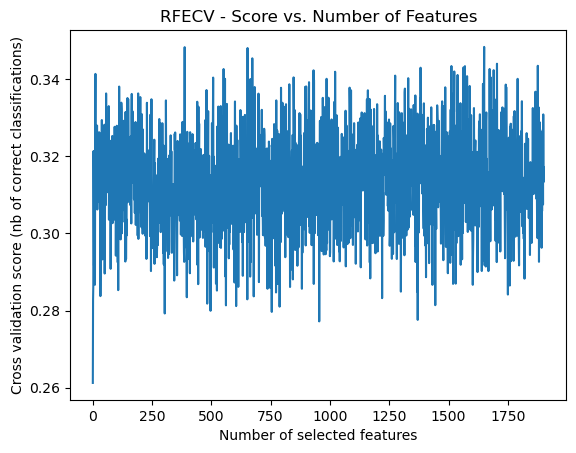

Original number of features (after RFECV): 1650
Number of components selected by PCA: 90


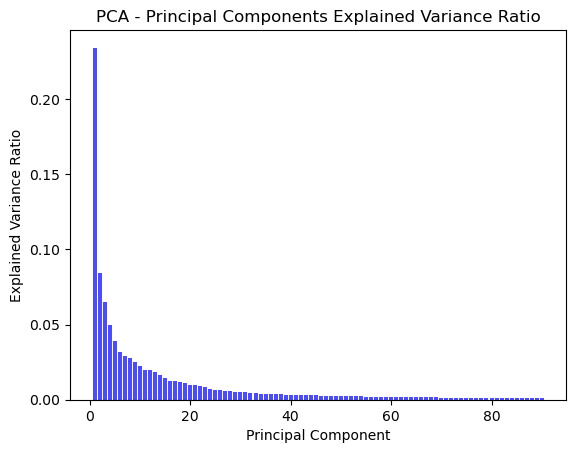

Final shape of the train dataset: (305, 90)
Final shape of the test dataset: (100, 90)
Final shape of the training part of the train dataset: (244, 90)
Final shape of the testing part of the train dataset: (61, 90)


In [6]:
model = RandomForestClassifier(random_state=2023)

### 1. RFECV - Recursive Feature Elimination with Cross-Validation
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, verbose=2)
rfecv.fit(X, y)

rfecv_features = X.columns[rfecv.support_]
print(f"Number of selected features by RFECV: {len(rfecv_features)}")
print(f"Eliminated features by RFECV: {len(X.columns) - len(rfecv_features)}")

plt.figure()
plt.xlabel("Number of selected features")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title("RFECV - Score vs. Number of Features")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

X_rfecv = X[rfecv_features]
X_test_rfecv = X_test[rfecv_features]
X_train_rfecv = X_train[rfecv_features]
X_val_rfecv = X_val[rfecv_features]

### 2. PCA - Principal Component Analysis
pca = PCA(n_components=0.95)
X_final = pca.fit_transform(X_rfecv)
X_test_final = pca.transform(X_test_rfecv)
X_train_final = pca.transform(X_train_rfecv)
X_val_final = pca.transform(X_val_rfecv)
print(f"Original number of features (after RFECV): {X_rfecv.shape[1]}")
print(f"Number of components selected by PCA: {pca.n_components_}")

plt.figure()
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, color='blue', alpha=0.7)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA - Principal Components Explained Variance Ratio")
plt.show()

# Final datasets for training and testing
print(f"Final shape of the train dataset: {X_final.shape}")
print(f"Final shape of the test dataset: {X_test_final.shape}")
print(f"Final shape of the training part of the train dataset: {X_train_final.shape}")
print(f"Final shape of the testing part of the train dataset: {X_val_final.shape}")

## **Modelos testados**

Decision Tree

In [7]:
dt = DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=25, min_samples_leaf=3, random_state=2023, splitter='random')
dt.fit(X_train_final, y_train)
dt_score = dt.score(X_val_final, y_val)
print("Accuracy: %.2f%%" % (dt_score * 100))

Accuracy: 34.43%


Support Vector Machine

In [8]:
svc = SVC(C=1, class_weight='balanced', decision_function_shape='ovo', degree=2, gamma=0.01, random_state=2023)
svc.fit(X_train_final, y_train)
svc_score = svc.score(X_val_final, y_val)
print("Accuracy: %.2f%%" % (svc_score * 100))

Accuracy: 34.43%


Random Forest

In [9]:
rf = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=5, max_features='log2', min_samples_split=10,random_state=2023)
rf.fit(X_train_final, y_train)
rf_score = rf.score(X_val_final, y_val)
print("Accuracy: %.2f%%" % (rf_score * 100))

Accuracy: 54.10%


MLP

In [10]:
mlp = MLPClassifier(activation='tanh', batch_size=32, hidden_layer_sizes=(100, 50), max_iter=1000, random_state=2023)
mlp.fit(X_train_final, y_train)
mlp_score = mlp.score(X_val_final, y_val)
print("Accuracy: %.2f%%" % (mlp_score * 100))

Accuracy: 39.34%


Gradient Boosting

In [11]:
gbc = GradientBoostingClassifier(criterion='squared_error', max_depth=5, max_features='log2', min_samples_leaf=4, random_state=2023)
gbc.fit(X_train_final, y_train)
gbc_score = gbc.score(X_val_final, y_val)
print("Accuracy: %.2f%%" % (gbc_score * 100))

Accuracy: 42.62%


XGBoost

In [12]:
xgboost = XGBClassifier(colsample_bytree=0.8, enable_categorical=False, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, missing=float('nan'), n_estimators=100, random_state=2023, reg_alpha=0, reg_lambda=0.1, subsample=0.8)

label_mapping = {'AD-AD': 0, 'CN-CN': 1, 'CN-MCI': 2, 'MCI-AD': 3, 'MCI-MCI': 4}
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

xgboost.fit(X_train_final, y_train)

xgboost_score = xgboost.score(X_val_final, y_val)
print("Accuracy: %.2f%%" % (xgboost_score * 100))
y_train = le.inverse_transform(y_train)
y_val = le.inverse_transform(y_val)

Accuracy: 50.82%


## Stacking Classifier

Accuracy: 31.15%
              precision    recall  f1-score   support

       AD-AD       0.29      0.33      0.31        12
       CN-CN       0.52      0.63      0.57        19
      CN-MCI       0.00      0.00      0.00         2
      MCI-AD       0.19      0.21      0.20        14
     MCI-MCI       0.00      0.00      0.00        14

    accuracy                           0.31        61
   macro avg       0.20      0.24      0.22        61
weighted avg       0.26      0.31      0.28        61



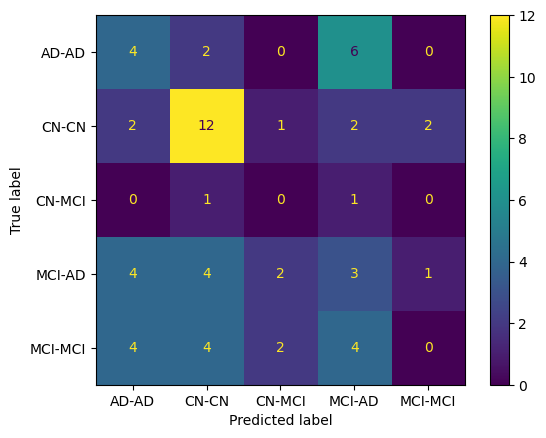

In [18]:
estimators = [("rf1", rf), ("rf2", rf), ("rf3", rf), ("rf4", rf), ("rf5", rf)]
stacking = StackingClassifier(estimators=estimators, final_estimator=rf, cv=5)
#estimators = [("dtc", dt), ("svm", svc), ("rf", rf), ("mlp", mlp), ("gbc", gbc), ("xgb", xgboost)]
#stacking = StackingClassifier(estimators=estimators, final_estimator=rf, cv=6)
#estimators = [("rf1", rf), ("rf2", rf), ("rf3", rf), ("xgb1", xgboost), ("xgb2", xgboost)]
#stacking = StackingClassifier(estimators=estimators, final_estimator=rf, cv=5)
stacking.fit(X_train_final, y_train)
stacking_score = stacking.score(X_val_final, y_val)
print("Accuracy: %.2f%%" % (stacking_score * 100))
stacking_predictions = stacking.predict(X_val_final)
print(classification_report(y_val, stacking_predictions))
ConfusionMatrixDisplay.from_predictions(y_val, stacking_predictions)
plt.show()

### Stacking Classifier Prediction

In [14]:
stacking.fit(X_final, y)
predictionsSTC = stacking.predict(X_test_final)

with open('../../predictions/stc.csv', 'w') as results:
    results.write('RowId,Result\n')
    i = 1
    for p in predictionsSTC:
        results.write(f'{i},{p}\n')
        i+=1